# TP2: PINNs et réduction de modèle
**Cours de SciML2**

### Emmanuel Franck  
1. Macaron Team, INRIA  
2. IRMA, Unistra  

---

## Résumé  
_Il s'agit de l'examen final du cours d'apprentissage et calcul scientifique._

---

<!-- ![Illustration du cube](cube.png) Remplacez "cube.png" par le lien ou l'emplacement de votre image -->

---

## 1. **Contexte**

On souhaite résoudre l'EDP de Burgers paramétrique visqueuse déterminée par la formule suivante :

$$
\partial_t u + \partial_x \left( \frac{u^2}{2} \right) - \varepsilon \partial_{xx} u = 0, \quad x \in [0, 1]
$$

avec les conditions initiales et aux limites suivantes :

$$
u(0, x) = u_0(x), \quad x \in [-1, 1]
$$
$$
u(t, -1) = u(t, 1) = 0, \quad t > 0
$$

où $\varepsilon \in [0.02, 0.2]$ représente le coefficient de viscosité.

---

## 2. **Exercice 1 : DF**

### Question 2.1 (Différences finies)  

**Énoncé :** Écrivez un code différences finies en PyTorch qui résout cette équation pour un $\varepsilon$ donné afin d'avoir des solutions de référence.

Vous pourrez utiliser les schémas du cours de **A. Thomann**, couplés avec :  
- un schéma classique pour la dérivée en temps,  
- une différence finie centrée pour la dérivée seconde.


# Résolution mathématique : Construction des matrices et schéma utilisé

## 1. Formulation de l'équation discrétisée

L'équation de Burgers paramétrique est donnée par :

$$
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(u^2\right) - \epsilon \frac{\partial^2 u}{\partial x^2} = 0, \quad x \in [-1, 1], \quad t > 0
$$

avec les conditions initiales et aux bords :

$$
u(0,x) = u_0(x), \quad u(t,-1) = u(t,1) = 0.
$$
### Discrétisation en temps et en espace

- **mail spatiale** : $ x_i = a + i \Delta x, \quad i = 0, 1, \dots, N_x - 1 $ où $ \Delta x = \frac{b - a }{N_x - 1} $.
- **mail temporelle** : $ t_n = n \Delta t, \quad n = 0, 1, \dots, N_t - 1 $.

Nous utilisons les différences finies pour discrétiser les dérivées temporelles et spatiales.

#### Dérivée Temporelle

La dérivée temporelle est approximée par un schéma explicite :

$$ \frac{\partial u}{\partial t} \approx \frac{u^{n+1}_i - u^n_i}{\Delta t} $$

#### Dérivée Première Spatiale

La dérivée première spatiale est approximée par une différence finie centrée :

$$ \frac{\partial u}{\partial x} \approx \frac{u_{i+1} - u_{i-1}}{2 \Delta x} $$

#### Dérivée Seconde Spatiale

La dérivée seconde spatiale est approximée par une différence finie centrée :

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} $$
L'équation discrétisée au temps $ t_{n+1} $ devient :

$$
u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{2\Delta x} \left(u_{i+1}^n - u_{i-1}^n \right) + \varepsilon \frac{\Delta t}{\Delta x^2} \left(u_{i+1}^n - 2 u_i^n + u_{i-1}^n \right)
$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import svd
from torch.utils.data import TensorDataset, DataLoader

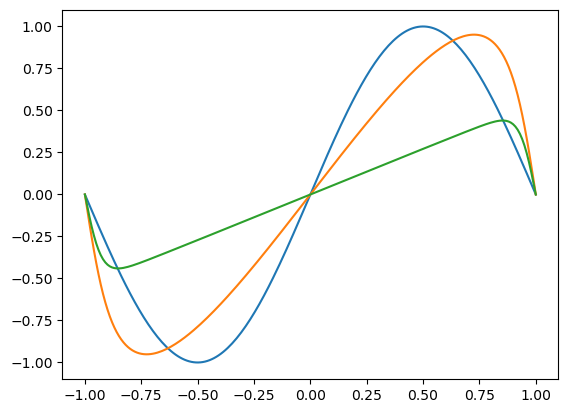

In [2]:
def scheme_refer(epsilon, L, nx, u0, T):
    dx = L / (nx - 1)  # Pas spatial
    # d'aprés la condition de stabilité, on a dt <= dx^2 / (2 * epsilon)
    dt = 0.1 * dx * epsilon  # Pas temporel
    Nt = int(T / dt)
    u = u0.clone().detach().numpy()

    # Boucle temporelle pour résoudre l'équation de Burgers
    if T == 0:
        return u0
    else:
        for n in range(Nt):
            un = u.copy()
            for i in range(1, nx-1):
                u[i] = un[i] - un[i] * dt / (2 * dx) * (un[i+1] - un[i-1]) + epsilon * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
            u[0] = 0  # Condition aux limites à x = -1
            u[-1] = 0  # Condition aux limites à x = 1

    return u

# Paramètres du problème
epsilon = 0.02  # Coefficient de viscosité
L = 2.0  # Longueur du domaine [-1, 1]
nx = 200  # Nombre de points spatiaux
T = 0.25  # Temps final
# Grille spatiale
x = np.linspace(-1, 1, nx)
# Condition initiale
u0_U0 = torch.sin(torch.tensor(np.pi * x, dtype=torch.float32))

T = [0 , 0.25, 1.5]
for t in T:
    u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
    plt.plot(x, u_refer, label='t = {}'.format(t))

## 3. **Exercice 1 : PINNs**

### Question 3.1 (PINNs)

**Énoncé :**  
Pouvez-vous, à l’aide d’un PINNs (Physically-Informed Neural Network), résoudre l’équation paramétrique précédente ?  
On cherchera donc une solution de type :  
$$
u_\theta(t, x, \varepsilon).
$$

Les conditions limites et initiales pourront être imposées :  
- **faiblement**,  
- **fortement**.  

**Consignes :**  
- Commentez dans votre rapport ce choix (imposition faible ou forte).  
- Fournissez une comparaison complète avec une solution de référence.  
- Réalisez une étude de l’effet des hyperparamètres.  
- Pour commencer, prenez un intervalle avec $\varepsilon$ plus petit.



### Cas 1:
Dans ce code, j'ai essayé de travailler avec des conditions faibles, telles que les conditions aux bords et les conditions initiales. Pour cela, j'ai ajouté ces conditions dans la fonction de perte avec les commandes suivantes :

```python
x_bnd = torch.cat([torch.full_like(t, -1), torch.full_like(t, 1)], dim=0)
t_bnd = torch.cat([t, t], dim=0)
u_bnd_pred = model(torch.cat([t_bnd, x_bnd], dim=1))
u_bnd_true = torch.zeros_like(u_bnd_pred)
loss_bnd = torch.mean((u_bnd_pred - u_bnd_true)**2)


Epoch 0, Loss: 0.5066006779670715
Epoch 1000, Loss: 0.05347869545221329
Epoch 2000, Loss: 0.029172291979193687
Epoch 3000, Loss: 0.01695689931511879
Epoch 4000, Loss: 0.013636210933327675


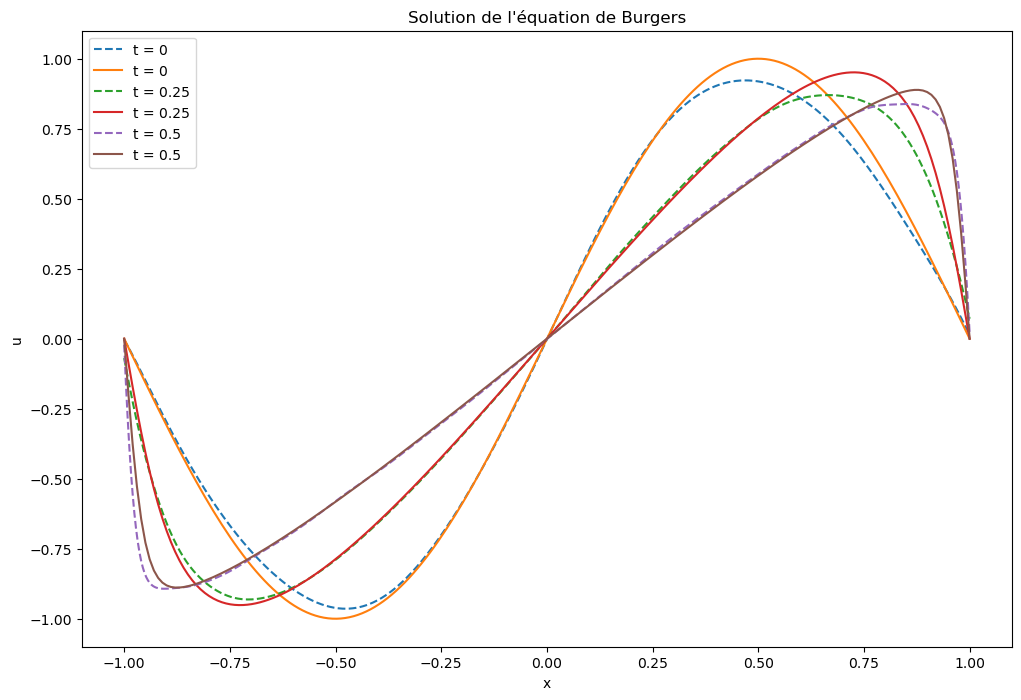

In [3]:
# Définition du réseau de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 50)  # Entrée: (t, x)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
    
    def forward(self, x):
        y = torch.sin(self.hidden1(x))
        z = torch.sin(self.hidden2(y))
        l = torch.sin(self.hidden3(z))
        l = torch.sin(self.hidden4(l))
        return self.output(l)  # Imposer les conditions aux limites

# Définition du résidu de l'équation
def residual(u, u_t, u_x, u_xx, epsilon):
    return u_t + u * u_x - epsilon * u_xx

# Fonction de perte
def loss_function(model, t, x, epsilon, u_true):
    inputs = torch.cat([t, x], dim=1)
    u_pred = model(inputs)
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    r = residual(u_pred, u_t, u_x, u_xx, epsilon)
    loss_f = torch.mean(r**2)
    
    # Conditions initiales
    u_ic_pred = model(torch.cat([torch.zeros_like(x), x], dim=1))
    loss_ic = torch.mean((u_ic_pred - u_true)**2)
    
    # Conditions aux limites
    x_bnd = torch.cat([torch.full_like(t, -1), torch.full_like(t, 1)], dim=0)
    t_bnd = torch.cat([t, t], dim=0)
    u_bnd_pred = model(torch.cat([t_bnd, x_bnd], dim=1))
    u_bnd_true = torch.zeros_like(u_bnd_pred)
    loss_bnd = torch.mean((u_bnd_pred - u_bnd_true)**2)
    
    return loss_f + loss_ic + loss_bnd

# Initialisation du modèle, de la perte et de l'optimiseur
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Données d'entraînement
t_train = torch.rand(1000, 1, requires_grad=True)
x_train = torch.rand(1000, 1, requires_grad=True) * 2 - 1
epsilon_train = 0.01
u_train = torch.sin(np.pi * x_train)

# Boucle d'entraînement
for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_function(model, t_train, x_train, epsilon_train, u_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Visualisation des résultats
with torch.no_grad():
    plt.figure(figsize=(12, 8))
    for t in [0, 0.25, 0.5]:
        t_test = torch.ones_like(x_train) * t
        x_test = torch.linspace(-1, 1, 1000).reshape(-1, 1)
        u_pred = model(torch.cat([t_test, x_test], dim=1)).detach().numpy()
        u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        plt.plot(x_test, u_pred, label=f't = {t}', linestyle='--')
        plt.plot(x, u_refer, label='t = {}'.format(t))
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.title('Solution de l\'équation de Burgers')
    plt.show()

### Calcule d'erreur avec la réference 

Epsilon: 0.02, Time: 0, Error: 0.08164628099516132
Epsilon: 0.02, Time: 0.2, Error: 0.08391222062055463
Epsilon: 0.02, Time: 0.4, Error: 0.10017688545704836
Epsilon: 0.02, Time: 0.5, Error: 0.07928838611862968
Epsilon: 0.02, Time: 1, Error: 0.04685247934083924
Epsilon: 0.065, Time: 0, Error: 0.04057368895997746
Epsilon: 0.065, Time: 0.2, Error: 0.044308164285703125
Epsilon: 0.065, Time: 0.4, Error: 0.029774042778221075
Epsilon: 0.065, Time: 0.5, Error: 0.0243798497647191
Epsilon: 0.065, Time: 1, Error: 0.012467057412103756
Epsilon: 0.11000000000000001, Time: 0, Error: 0.020752227594524376
Epsilon: 0.11000000000000001, Time: 0.2, Error: 0.007495817256982795
Epsilon: 0.11000000000000001, Time: 0.4, Error: 0.005320315947114659
Epsilon: 0.11000000000000001, Time: 0.5, Error: 0.005191562571355905
Epsilon: 0.11000000000000001, Time: 1, Error: 0.004871378227355912
Epsilon: 0.155, Time: 0, Error: 0.020089732235653326
Epsilon: 0.155, Time: 0.2, Error: 0.00867180561070957
Epsilon: 0.155, Time: 0

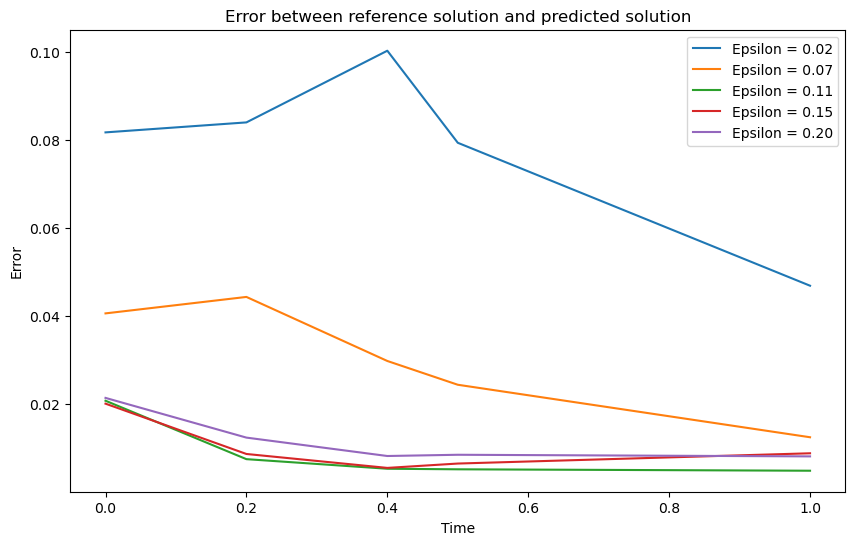

In [4]:
# Fonction pour calculer l'erreur entre la solution de référence et la solution prédite
def calculate_error(model, epsilons, times, L, nx, u0_U0):
    errors = []
    for epsilon in epsilons:
        # Initialisation du modèle, de la perte et de l'optimiseur
        model = PINN()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Données d'entraînement
        t_train = torch.rand(1000, 1, requires_grad=True)
        x_train = torch.rand(1000, 1, requires_grad=True) * 2 - 1
        u_train = torch.sin(np.pi * x_train)

        # Boucle d'entraînement
        for epoch in range(5000):
            optimizer.zero_grad()
            loss = loss_function(model, t_train, x_train, epsilon, u_train)
            loss.backward(retain_graph=True)
            optimizer.step()
            # if epoch % 500 == 0:
            #     print(f'Epoch {epoch}, Epsilon {epsilon}, Loss: {loss.item()}')
    
        for t in times:
            u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
            t_test = torch.ones_like(x_train) * t
            x_test = torch.linspace(-1, 1, 1000).reshape(-1, 1)
            u_pred = model(torch.cat([t_test, x_test], dim=1)).detach().numpy().flatten()
        
            # Interpoler la solution prédite pour qu'elle corresponde à la grille de la solution de référence
            interp_func = interp1d(x_test.flatten(), u_pred, kind='cubic', fill_value="extrapolate")
            u_pred_interp = interp_func(np.linspace(-1, 1, nx))
        
            error = np.linalg.norm(u_refer - u_pred_interp, ord=2)
            errors.append((epsilon, t, error))
            # print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')
    return errors

# Tester le modèle avec différentes valeurs de epsilon et de T
epsilons = np.linspace(0.02, 0.2, 5)
times = [0, 0.2, 0.4, 0.5, 1]
errors = calculate_error(model, epsilons, times, L, nx, u0_U0)

# Afficher les erreurs
for epsilon, t, error in errors:
    print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')

# Tracer les erreurs
errors_array = np.array(errors)
fig, ax = plt.subplots(figsize=(10, 6))
for epsilon in epsilons:
    mask = errors_array[:, 0] == epsilon
    ax.plot(errors_array[mask, 1], errors_array[mask, 2], label=f'Epsilon = {epsilon:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Error between reference solution and predicted solution')
ax.legend()
plt.show()

### Cas 2 :
Dans ce deuxième cas, j'ai essayé de travailler avec des conditions fortes, telles que :

$$ h(x) = (1-x)(1+x) $$

Il est facile de vérifier que cette fonction réalise bien les conditions de bord demandées par l'énoncé

Epoch 0, Loss: 0.5306260585784912
Epoch 500, Loss: 0.08991489559412003
Epoch 1000, Loss: 0.06225147098302841
Epoch 1500, Loss: 0.03566247224807739
Epoch 2000, Loss: 0.022232666611671448
Epoch 2500, Loss: 0.016859307885169983
Epoch 3000, Loss: 0.011954410001635551
Epoch 3500, Loss: 0.009994564577937126
Epoch 4000, Loss: 0.007867978885769844
Epoch 4500, Loss: 0.013347569853067398


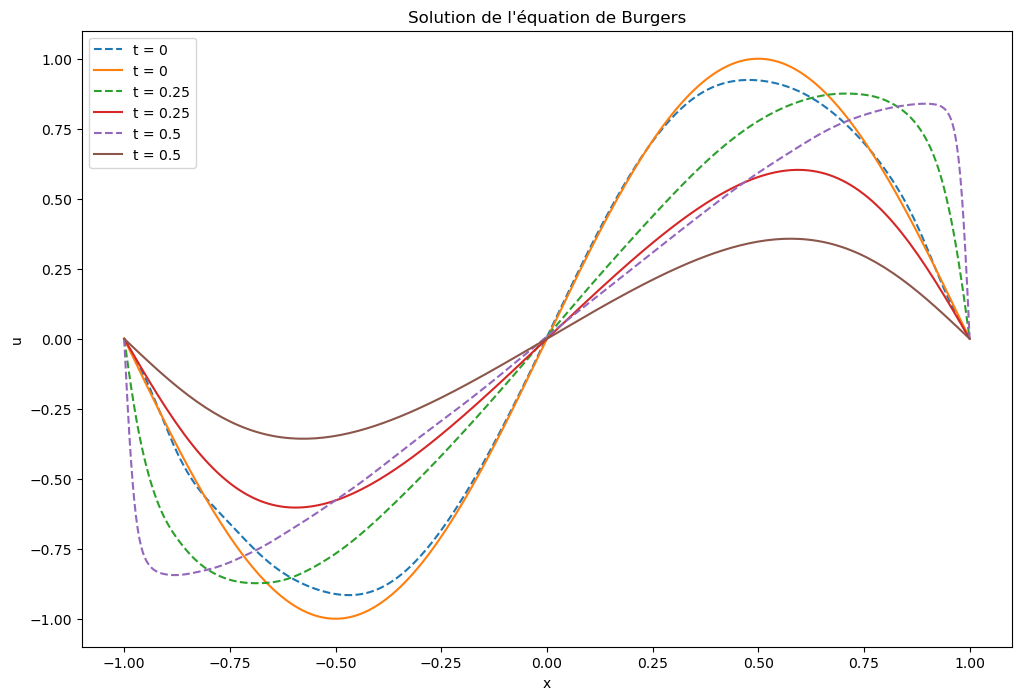

In [5]:
# Définition du réseau de neurones
class PINNs(nn.Module):
    def __init__(self):
        super(PINNs, self).__init__()
        self.hidden1 = nn.Linear(2, 50)  # Entrée: (t, x)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
    
    def forward(self, x):
        y = torch.sin(self.hidden1(x))
        z = torch.sin(self.hidden2(y))
        l = torch.sin(self.hidden3(z))
        l = torch.sin(self.hidden4(l))
        return self.output(l) * (1 + x[:,1:2])  * (1 - x[:,1:2]) # Imposer les conditions aux limites

# Définition du résidu de l'équation
def residual(u, u_t, u_x, u_xx, epsilon):
    return u_t + u * u_x - epsilon * u_xx

# Fonction de perte
def loss_function(model, t, x, epsilon, u_true):
    inputs = torch.cat([t, x], dim=1)
    u_pred = model(inputs)
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    r = residual(u_pred, u_t, u_x, u_xx, epsilon)
    loss_f = torch.mean(r**2)
    
    # Conditions initiales
    u_ic_pred = model(torch.cat([torch.zeros_like(x), x], dim=1))
    loss_ic = torch.mean((u_ic_pred - u_true)**2)
    
    return loss_f + loss_ic 

# Initialisation du modèle, de la perte et de l'optimiseur
model = PINNs()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Données d'entraînement
t_train = torch.rand(1000, 1, requires_grad=True)
x_train = torch.rand(1000, 1, requires_grad=True) * 2 - 1
epsilon_train = 0.01
u_train = torch.sin(np.pi * x_train)

# Boucle d'entraînement
for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_function(model, t_train, x_train, epsilon_train, u_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Visualisation des résultats
with torch.no_grad():
    plt.figure(figsize=(12, 8))
    for t in [0, 0.25, 0.5]:
        t_test = torch.ones_like(x_train) * t
        x_test = torch.linspace(-1, 1, 1000).reshape(-1, 1)
        u_pred = model(torch.cat([t_test, x_test], dim=1)).detach().numpy()
        u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        plt.plot(x_test, u_pred, label=f't = {t}', linestyle='--')
        plt.plot(x, u_refer, label='t = {}'.format(t))
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.title('Solution de l\'équation de Burgers')
    plt.show()

### Calcule d'erreur avec la réference 

Epsilon: 0.02, Time: 0, Error: 0.12706339758646812
Epsilon: 0.02, Time: 0.2, Error: 0.13227753821862018
Epsilon: 0.02, Time: 0.4, Error: 0.13790023087599726
Epsilon: 0.02, Time: 0.5, Error: 0.10964371889076596
Epsilon: 0.02, Time: 1, Error: 0.036712827589613826
Epsilon: 0.065, Time: 0, Error: 0.013523304132985034
Epsilon: 0.065, Time: 0.2, Error: 0.0033451892904388385
Epsilon: 0.065, Time: 0.4, Error: 0.0035236613047959528
Epsilon: 0.065, Time: 0.5, Error: 0.004590798258111692
Epsilon: 0.065, Time: 1, Error: 0.002931296343386463
Epsilon: 0.11000000000000001, Time: 0, Error: 0.017208572511369237
Epsilon: 0.11000000000000001, Time: 0.2, Error: 0.005762313753606258
Epsilon: 0.11000000000000001, Time: 0.4, Error: 0.003542833698016346
Epsilon: 0.11000000000000001, Time: 0.5, Error: 0.0037143685676731476
Epsilon: 0.11000000000000001, Time: 1, Error: 0.002081017217949238
Epsilon: 0.155, Time: 0, Error: 0.017578950171404435
Epsilon: 0.155, Time: 0.2, Error: 0.014869591773110038
Epsilon: 0.155,

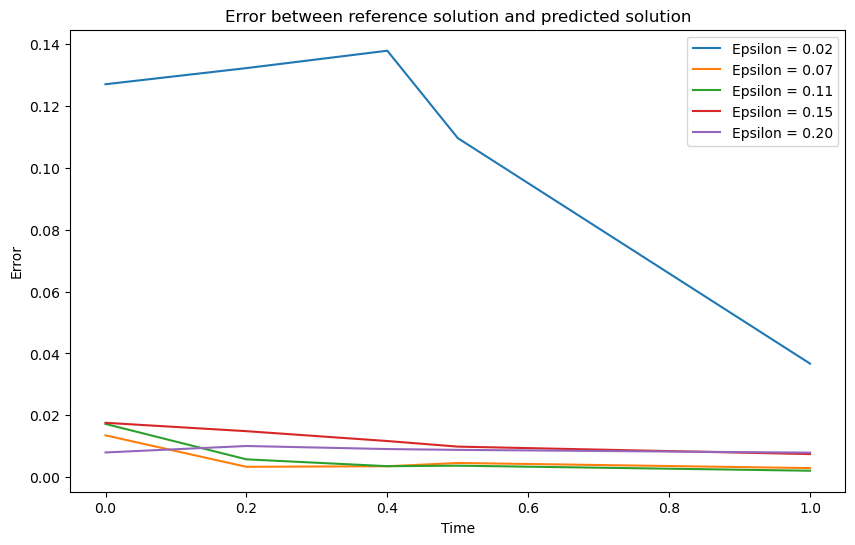

In [6]:
# Fonction pour calculer l'erreur entre la solution de référence et la solution prédite
def calculate_error(model, epsilons, times, L, nx, u0_U0):
    errors = []
    for epsilon in epsilons:
        # Initialisation du modèle, de la perte et de l'optimiseur
        model = PINNs()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Données d'entraînement
        t_train = torch.rand(1000, 1, requires_grad=True)
        x_train = torch.rand(1000, 1, requires_grad=True) * 2 - 1
        u_train = torch.sin(np.pi * x_train)

        # Boucle d'entraînement
        for epoch in range(5000):
            optimizer.zero_grad()
            loss = loss_function(model, t_train, x_train, epsilon, u_train)
            loss.backward(retain_graph=True)
            optimizer.step()
            # if epoch % 500 == 0:
            #     print(f'Epoch {epoch}, Epsilon {epsilon}, Loss: {loss.item()}')
    
        for t in times:
            u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
            t_test = torch.ones_like(x_train) * t
            x_test = torch.linspace(-1, 1, 1000).reshape(-1, 1)
            u_pred = model(torch.cat([t_test, x_test], dim=1)).detach().numpy().flatten()
        
            # Interpoler la solution prédite pour qu'elle corresponde à la grille de la solution de référence
            interp_func = interp1d(x_test.flatten(), u_pred, kind='cubic', fill_value="extrapolate")
            u_pred_interp = interp_func(np.linspace(-1, 1, nx))
        
            error = np.linalg.norm(u_refer - u_pred_interp, ord=2)
            errors.append((epsilon, t, error))
    return errors

# Tester le modèle avec différentes valeurs de epsilon et de T
epsilons = np.linspace(0.02, 0.2, 5)
times = [0, 0.2, 0.4, 0.5, 1]
errors = calculate_error(model, epsilons, times, L, nx, u0_U0)

            #     print(f'Epoch {epoch}, Epsilon {epsilon}, Loss: {loss.item()}')
# Afficher les erreurs
for epsilon, t, error in errors:
    print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')

# Tracer les erreurs
errors_array = np.array(errors)
fig, ax = plt.subplots(figsize=(10, 6))
for epsilon in epsilons:
    mask = errors_array[:, 0] == epsilon
    ax.plot(errors_array[mask, 1], errors_array[mask, 2], label=f'Epsilon = {epsilon:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Error between reference solution and predicted solution')
ax.legend()
plt.show()




### Question 3.2 (PINNs discret)

**Énoncé :**  
Résolvez la même équation à l’aide d’un PINNs **discret**, en calculant :  
$$
u_{\theta(t)}(x, \varepsilon).
$$

**Consignes :**  
- Effectuez des comparaisons pertinentes avec l’approche précédente (PINNs classique).
- Discutez des performances et des résultats obtenus.


**Remarque générale :**  
Pour les deux questions, il est attendu une implémentation avec des comparaisons rigoureuses, des graphiques et des commentaires sur la qualit

Dans cette question, je me suis basé sur [cet article](https://www.ijcai.org/proceedings/2024/0497.pdf), le cours, ainsi que des recherches sur Google pour obtenir de bons résultats. Même si le code prend un peu de temps pour la prédiction, il reste une bonne solution en termes de résultats. Plus précisément, j'ai utilisé la méthode de Euler backourd.

Pour approximer la solution $ u(n\Delta t, x) $, nous considérons la recherche de $ u^{n+1}(x) $ en utilisant le schéma de différenciation temporelle de Euler backourd :

$$
\frac{u^{n+1}(x) - u^n(x)}{\Delta t} = N \left( u^{n+1}(x) \right).
$$

Au lieu de résoudre notre problème initial dans tout le domaine espace-temps, j'ai utilisé les conditions fortes pour le bord :

$$
h(x) = (1-x)(1+x)
$$

On commence par faire une PINNs discrète sans le transfert d'apprentissage.

Time step 1/100, Loss: 1.7821346521377563
Time step 2/100, Loss: 0.012736800126731396
Time step 3/100, Loss: 0.004460989497601986
Time step 4/100, Loss: 0.3010292053222656
Time step 5/100, Loss: 0.004161367192864418
Time step 6/100, Loss: 0.0050934380851686
Time step 7/100, Loss: 0.007678915746510029
Time step 8/100, Loss: 0.007797615136951208
Time step 9/100, Loss: 0.005324906669557095
Time step 10/100, Loss: 0.0031677272636443377
Time step 11/100, Loss: 0.0022484404034912586
Time step 12/100, Loss: 0.0026458767242729664
Time step 13/100, Loss: 0.0023696317803114653
Time step 14/100, Loss: 0.0020713857375085354
Time step 15/100, Loss: 0.0025754731614142656
Time step 16/100, Loss: 0.005496221128851175
Time step 17/100, Loss: 0.0022694540675729513
Time step 18/100, Loss: 0.0019146907143294811
Time step 19/100, Loss: 0.002969978842884302
Time step 20/100, Loss: 0.0021660488564521074
Time step 21/100, Loss: 0.0029014793690294027
Time step 22/100, Loss: 0.003342580981552601
Time step 23/10

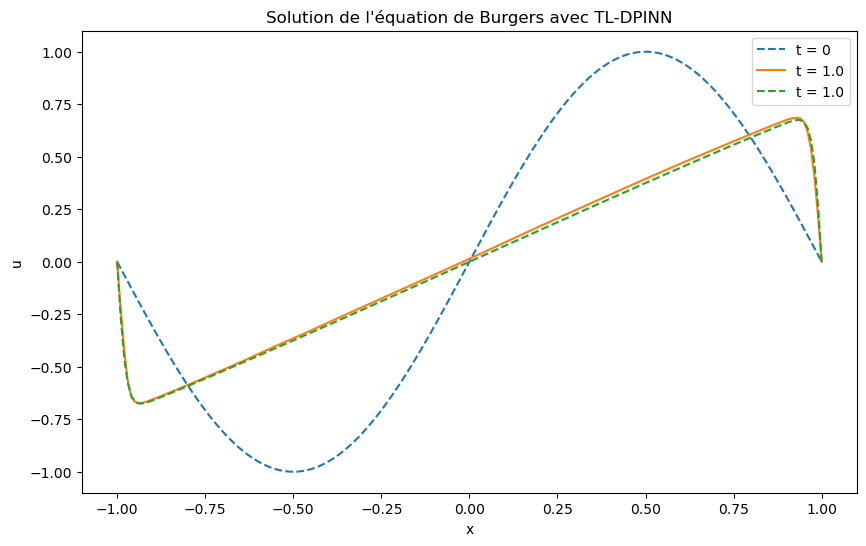

In [7]:
# Définition du réseau de neurones
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 50)  # Couche d'entrée : x
        self.fc2 = nn.Linear(50, 50) # Couche cachée
        self.fc3 = nn.Linear(50, 50)  # Couche de sortie : u(x)
        self.fc4 = nn.Linear(50, 1)  # Couche de sortie : u(x)
    
    def forward(self, x):
        y = torch.tanh(self.fc1(x))
        y = torch.tanh(self.fc2(y))
        y = torch.tanh(self.fc3(y))
        return self.fc4(y) * (1 + x) * (1 - x)  # Imposer les conditions aux limites

# Paramètres
epsilon = 0.01  # Coefficient de viscosité
dt = 0.01       # Pas de temps
T = 1.0        # Temps final
nx = 200        # Nombre de points spatiaux
x = torch.linspace(-1, 1, nx).reshape(-1, 1)  # Grille spatiale
u0 = torch.sin(np.pi * x)  # Condition initiale

# Initialisation du modèle
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Boucle temporelle
u = u0.clone()
for n in range(int(T / dt)):
    # Entraînement du modèle pour u^{n+1}
    for _ in range(1000):  # Nombre d'itérations par pas de temps
        optimizer.zero_grad()
        
        # Calcul des dérivées spatiales
        x.requires_grad_()
        u_pred = model(x)
        # Résidu de l'équation discrétisée
        u_avg = u_pred 
        u_avg_x = torch.autograd.grad(u_avg, x, grad_outputs=torch.ones_like(u_avg), create_graph=True)[0]
        u_avg_xx = torch.autograd.grad(u_avg_x, x, grad_outputs=torch.ones_like(u_avg_x), create_graph=True)[0]
        residual = (u_pred - u) / dt + u_avg * u_avg_x - epsilon * u_avg_xx
        # Fonction de perte
        loss = torch.mean(residual**2) 
        loss.backward()
        optimizer.step()
    
    # Mise à jour de u pour le pas de temps suivant
    u = u_pred.detach()
    print(f"Time step {n+1}/{int(T / dt)}, Loss: {loss.item()}")
    # print(f"Time step {n+1}/{int(T / dt)}, Loss: {loss.item()}")
u_refer = scheme_refer(epsilon, 2, nx, u0, T)
# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(x.detach().numpy(), u0.detach().numpy(), label='t = 0', linestyle='--')
plt.plot(x.detach().numpy(), u_pred.detach().numpy(), label=f't = {T}')
plt.plot(x.detach().numpy(), u_refer, label='t = {}'.format(T),linestyle='--')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Solution de l\'équation de Burgers avec TL-DPINN')
plt.show()

Dans ce code, nous allons faire une PINNs discrète par transfert d'apprentissage.

Epsilon: 0.02, Time: 0, Error: 6.083807945251465
Epsilon: 0.02, Time: 0.2, Error: 4.633492946624756
Epsilon: 0.02, Time: 0.4, Error: 3.387033224105835
Epsilon: 0.02, Time: 0.5, Error: 2.7867002487182617
Epsilon: 0.02, Time: 1, Error: 0.5105993747711182
Epsilon: 0.065, Time: 0, Error: 6.241040229797363
Epsilon: 0.065, Time: 0.2, Error: 4.620893955230713
Epsilon: 0.065, Time: 0.4, Error: 3.2010622024536133
Epsilon: 0.065, Time: 0.5, Error: 2.529754161834717
Epsilon: 0.065, Time: 1, Error: 0.18642237782478333
Epsilon: 0.11000000000000001, Time: 0, Error: 7.155239582061768
Epsilon: 0.11000000000000001, Time: 0.2, Error: 5.050556659698486
Epsilon: 0.11000000000000001, Time: 0.4, Error: 3.2658917903900146
Epsilon: 0.11000000000000001, Time: 0.5, Error: 2.512808322906494
Epsilon: 0.11000000000000001, Time: 1, Error: 0.24622806906700134
Epsilon: 0.155, Time: 0, Error: 8.009161949157715
Epsilon: 0.155, Time: 0.2, Error: 5.2836408615112305
Epsilon: 0.155, Time: 0.4, Error: 3.204181432723999
Epsi

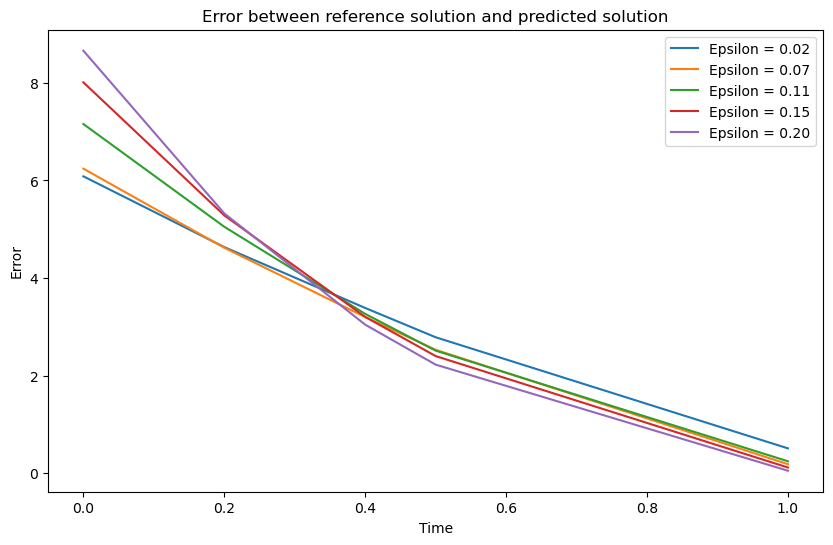

In [9]:

# Fonction pour calculer l'erreur entre la solution de référence et la solution prédite
def calculate_error(epsilons, times, L, nx, u0_U0):
    errors = []
    for epsilon in epsilons:
        # Initialisation du modèle, de la perte et de l'optimiseur
        dt = 0.01
        T = 1.0
        learning_rate = 0.001

        # Données d'entraînement
        x_train = torch.linspace(-1, 1, nx).reshape(-1, 1)
        u_train = torch.sin(np.pi * x_train)

        # Initialisation du modèle
        model = NeuralNetwork()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Boucle temporelle
        u = u_train.clone()
        for n in range(int(T / dt)):
            for _ in range(1000):  # Nombre d'itérations par pas de temps
                optimizer.zero_grad()
                
                # Calcul des dérivées spatiales
                x_train.requires_grad_()
                u_pred = model(x_train)
                u_avg = u_pred
                u_avg_x = torch.autograd.grad(u_avg, x_train, grad_outputs=torch.ones_like(u_avg), create_graph=True)[0]
                u_avg_xx = torch.autograd.grad(u_avg_x, x_train, grad_outputs=torch.ones_like(u_avg_x), create_graph=True)[0]
                residual = (u_pred - u) / dt + u_avg * u_avg_x - epsilon * u_avg_xx
                loss = torch.mean(residual**2)
                loss.backward()
                optimizer.step()
            
            # Mise à jour de u pour le pas de temps suivant
            u = u_pred.detach()

        for t in times:
            u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
            x_test = torch.linspace(-1, 1, nx).reshape(-1, 1)
            u_pred = model(x_test).detach().numpy().flatten()
            
            # # Interpoler la solution prédite pour qu'elle corresponde à la grille de la solution de référence
            # interp_func = interp1d(x_test.flatten(), u_pred, kind='cubic', fill_value="extrapolate")
            # u_pred_interp = interp_func(np.linspace(-1, 1, nx))
        
            error = np.linalg.norm(u_refer - u_pred, ord=2)
            errors.append((epsilon, t, error))
            print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')
    return errors

# Tester le modèle avec différentes valeurs de epsilon et de T
epsilons = np.linspace(0.02, 0.2, 5)
times = [0, 0.2, 0.4, 0.5, 1]
errors = calculate_error(epsilons, times, L, nx, u0_U0)

# Afficher les erreurs
for epsilon, t, error in errors:
    print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')

# Tracer les erreurs
errors_array = np.array(errors)
fig, ax = plt.subplots(figsize=(10, 6))
for epsilon in epsilons:
    mask = errors_array[:, 0] == epsilon
    ax.plot(errors_array[mask, 1], errors_array[mask, 2], label=f'Epsilon = {epsilon:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Error between reference solution and predicted solution')
ax.legend()
plt.show()

Initial Epoch 0, Loss: 0.46629074215888977


Initial Epoch 500, Loss: 0.00010955347534036264
Initial Epoch 1000, Loss: 9.732021135278046e-05
Initial Epoch 1500, Loss: 8.257209992734715e-05
Initial Epoch 2000, Loss: 6.589011900359765e-05
Initial Epoch 2500, Loss: 8.218376751756296e-05
Initial Epoch 3000, Loss: 2.0457566279219463e-05
Initial Epoch 3500, Loss: 2.591875954749412e-06
Initial Epoch 4000, Loss: 1.729701921249216e-06
Initial Epoch 4500, Loss: 4.639636244974099e-06
Time 0.01, Epoch 0, Loss: 1.233117938041687
Time 0.01, Epoch 100, Loss: 0.01567828468978405
Time 0.01, Epoch 200, Loss: 0.004381334409117699
Time 0.01, Epoch 300, Loss: 0.002488001948222518
Time 0.01, Epoch 400, Loss: 0.0021473891101777554
Convergence reached at Time 0.01, Epoch 475, Loss: 0.0019674513023346663
Time 0.02, Epoch 0, Loss: 1.219051480293274
Time 0.02, Epoch 100, Loss: 0.008793613873422146
Time 0.02, Epoch 200, Loss: 0.003394034691154957
Time 0.02, Epoch 300, Loss: 0.002688694978132844
Time 0.02, Epoch 400, Loss: 0.0023995740339159966
Convergence r

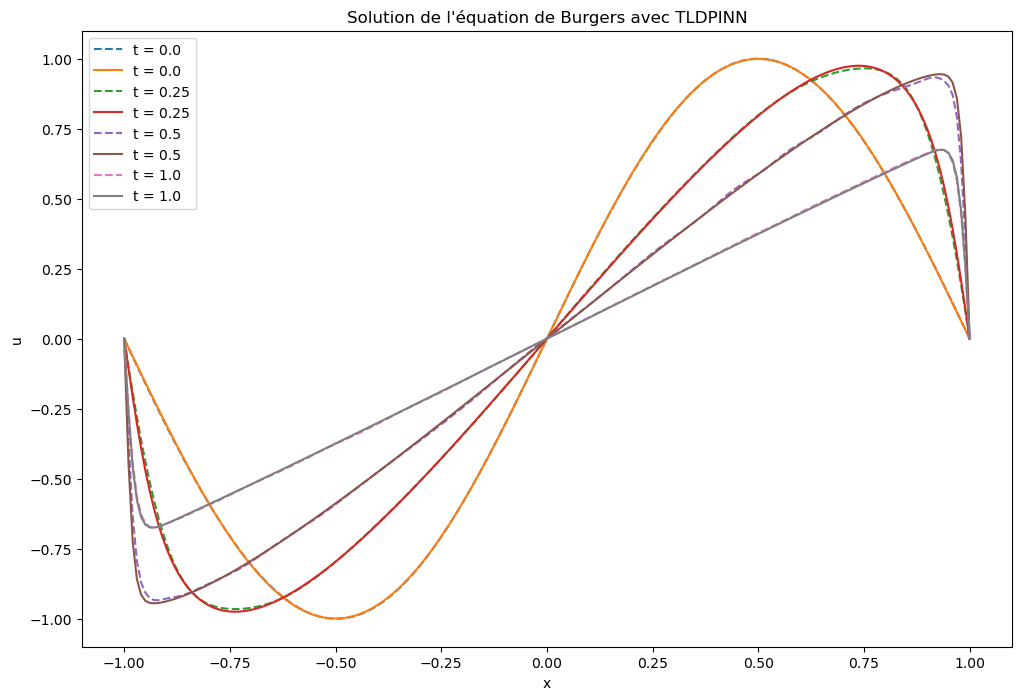

In [10]:

# Définition du réseau de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(1, 50)  # Entrée: (x)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
    
    def forward(self, x):
        y = torch.sin(self.hidden1(x))
        z = torch.sin(self.hidden2(y))
        l = torch.sin(self.hidden3(z))
        l = torch.sin(self.hidden4(l))
        return self.output(l) * (1 + x) * (1 - x)  # Imposer les conditions aux limites

# Définition du résidu de l'équation
def residual(u, u_x, u_xx, epsilon):
    return - u * u_x + epsilon * u_xx

# Fonction de perte pour le schéma de Crank-Nicolson
def loss_function_discret(model, model_prev, x, epsilon, dt):
    x.requires_grad_()
    u_pred = model(x)
    u_prev = model_prev(x).detach()
    
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    r = residual(u_pred, u_x, u_xx, epsilon)
    loss_f = torch.mean(((u_pred - u_prev) / dt - r)**2)
    
    return loss_f

# Initialisation du modèle, de la perte et de l'optimiseur
epsilon = 0.01
dt = 0.01
epochs_initial = 5000
epochs_transfer = 5000
learning_rate = 0.001
threshold = 1e-6
times = np.arange(0, 1.01, dt)

# Données d'entraînement
x_train = torch.linspace(-1, 1, 200).reshape(-1, 1)
u_train = torch.sin(np.pi * x_train)

# Initialisation du premier modèle avec les conditions initiales
model_prev = PINN()
optimizer = optim.Adam(model_prev.parameters(), lr=learning_rate)

# Entraînement du premier modèle
for epoch in range(epochs_initial):
    optimizer.zero_grad()
    u_pred = model_prev(x_train)
    loss = torch.mean((u_pred - u_train)**2)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Initial Epoch {epoch}, Loss: {loss.item()}')

# Boucle d'entraînement pour chaque instant de temps
models = {0: model_prev}
for t in times[1:]:
    model = PINN()
    model.load_state_dict(model_prev.state_dict())  # Apprentissage par transfert
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    prev_loss = float('inf')
    
    for epoch in range(epochs_transfer):
        optimizer.zero_grad()
        loss = loss_function_discret(model, model_prev, x_train, epsilon, dt)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Time {t:.2f}, Epoch {epoch}, Loss: {loss.item()}')
        
        # Vérification du critère d'arrêt
        if abs(prev_loss - loss.item()) < threshold:
            print(f'Convergence reached at Time {t:.2f}, Epoch {epoch}, Loss: {loss.item()}')
            break
        prev_loss = loss.item()
    
    models[t] = model
    model_prev = model

# Visualisation des résultats
with torch.no_grad():
    plt.figure(figsize=(12, 8))
    for t in [0, 0.25, 0.5, 1]:
        t = round(t / dt) * dt  # Assurer que t est un multiple de dt
        x_test = torch.linspace(-1, 1, 200).reshape(-1, 1)
        u_pred = models[t](x_test).detach().numpy()
        u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        plt.plot(x_test.numpy(), u_pred, label=f't = {t}', linestyle='--')
        plt.plot(x, u_refer, label='t = {}'.format(t))
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.title('Solution de l\'équation de Burgers avec TLDPINN')
    plt.show()

Epsilon: 0.02, Time: 0, Error: 0.022052601911549494
Epsilon: 0.02, Time: 0.2, Error: 0.06647852929546126
Epsilon: 0.02, Time: 0.4, Error: 0.13018169328950274
Epsilon: 0.02, Time: 0.5, Error: 0.12528815061486756
Epsilon: 0.02, Time: 1, Error: 0.04055572462810405
Epsilon: 0.065, Time: 0, Error: 0.25348470131260586
Epsilon: 0.065, Time: 0.2, Error: 0.22689420380756614
Epsilon: 0.065, Time: 0.4, Error: 0.20956667117090239
Epsilon: 0.065, Time: 0.5, Error: 0.18746138913667393
Epsilon: 0.065, Time: 1, Error: 0.12538163597482233
Epsilon: 0.11000000000000001, Time: 0, Error: 0.012913626812978692
Epsilon: 0.11000000000000001, Time: 0.2, Error: 0.07243639057384027
Epsilon: 0.11000000000000001, Time: 0.4, Error: 0.04622813294462207
Epsilon: 0.11000000000000001, Time: 0.5, Error: 0.035715799111272754
Epsilon: 0.11000000000000001, Time: 1, Error: 0.02910393443466743
Epsilon: 0.155, Time: 0, Error: 0.014300256359361392
Epsilon: 0.155, Time: 0.2, Error: 0.05131840484821596
Epsilon: 0.155, Time: 0.4, 

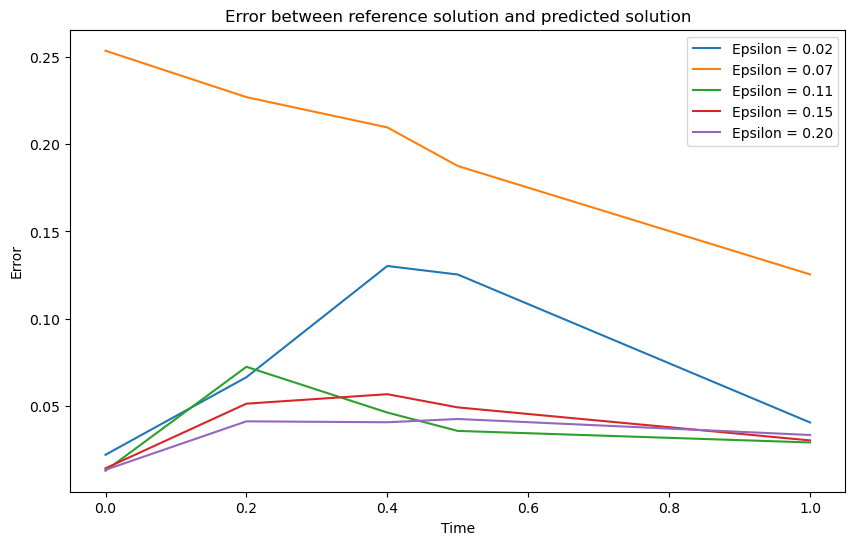

In [11]:
# Fonction pour calculer l'erreur entre la solution de référence et la solution prédite
def calculate_error(epsilons, times, L, nx, u0_U0):
    errors = []
    for epsilon in epsilons:
        # Initialisation du modèle, de la perte et de l'optimiseur
        dt = 0.01
        epochs_initial = 5000
        epochs_transfer = 5000
        learning_rate = 0.001
        threshold = 1e-6
        times_train = np.arange(0, 1.01, dt)

        # Données d'entraînement
        x_train = torch.linspace(-1, 1, 200).reshape(-1, 1)
        u_train = torch.sin(np.pi * x_train)

        # Initialisation du premier modèle avec les conditions initiales
        model_prev = PINN()
        optimizer = optim.Adam(model_prev.parameters(), lr=learning_rate)

        # Entraînement du premier modèle
        for epoch in range(epochs_initial):
            optimizer.zero_grad()
            u_pred = model_prev(x_train)
            loss = torch.mean((u_pred - u_train)**2)
            loss.backward()
            optimizer.step()
            # if epoch % 500 == 0:
                # print(f'Initial Epoch {epoch}, Loss: {loss.item()}')

        # Boucle d'entraînement pour chaque instant de temps
        models = {0: model_prev}
        for t in times_train[1:]:
            model = PINN()
            model.load_state_dict(model_prev.state_dict())  # Apprentissage par transfert
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            prev_loss = float('inf')
            
            for epoch in range(epochs_transfer):
                optimizer.zero_grad()
                loss = loss_function_discret(model, model_prev, x_train, epsilon, dt)
                loss.backward()
                optimizer.step()
                
                # if epoch % 500 == 0:
                #     print(f'Time {t:.2f}, Epoch {epoch}, Loss: {loss.item()}')
                
                # Vérification du critère d'arrêt
                if abs(prev_loss - loss.item()) < threshold:
                    # print(f'Convergence reached at Time {t:.2f}, Epoch {epoch}, Loss: {loss.item()}')
                    break
                prev_loss = loss.item()
            
            models[t] = model
            model_prev = model

        for t in times:
            u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
            x_test = torch.linspace(-1, 1, nx).reshape(-1, 1)
            u_pred = models[t](x_test).detach().numpy().flatten()
            
            # Interpoler la solution prédite pour qu'elle corresponde à la grille de la solution de référence
            interp_func = interp1d(x_test.flatten(), u_pred, kind='cubic', fill_value="extrapolate")
            u_pred_interp = interp_func(np.linspace(-1, 1, nx))
        
            error = np.linalg.norm(u_refer - u_pred_interp, ord=2)
            errors.append((epsilon, t, error))
            # print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')
    return errors

# Tester le modèle avec différentes valeurs de epsilon et de T
epsilons = np.linspace(0.02, 0.2, 5)
times = [0, 0.2, 0.4, 0.5, 1]
errors = calculate_error(epsilons, times, L, nx, u0_U0)

# Afficher les erreurs
for epsilon, t, error in errors:
    print(f'Epsilon: {epsilon}, Time: {t}, Error: {error}')

# Tracer les erreurs
errors_array = np.array(errors)
fig, ax = plt.subplots(figsize=(10, 6))
for epsilon in epsilons:
    mask = errors_array[:, 0] == epsilon
    ax.plot(errors_array[mask, 1], errors_array[mask, 2], label=f'Epsilon = {epsilon:.2f}')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.set_title('Error between reference solution and predicted solution')
ax.legend()
plt.show()

## **Exercice 2: Réduction de modèle**

### Question 4.1 (Données)
Générer un tenseur de données qui contient des solutions spatiales de notre EDP pour plusieurs temps et valeur de epsilon.

### Question 4.2 (Réduction de dimension)
Utilisez une méthode POD pour construire notre espace réduit.

### Question 4.3 (Réduction de modèle)
Calculer le modèle réduit (sans hyper-réduction) par la méthode de Galerkin, comparez les résultats aux solutions de références et aux solutions PINNs pour plusieurs dimensions de réduction.

### Question 4.4 (Apprentissage de modèle)
Apprenez le modèle réduit par une approche supervisée et comparez les résultats aux solutions de références et aux solutions PINNs pour plusieurs dimensions de réduction.

# Réponce

### Question 4.1 (Données)
Générer un tenseur de données qui contient des solutions spatiales de notre EDP pour plusieurs temps et valeur de epsilon.


J'ai généré des données pour différents $t$ et différents epsilon.

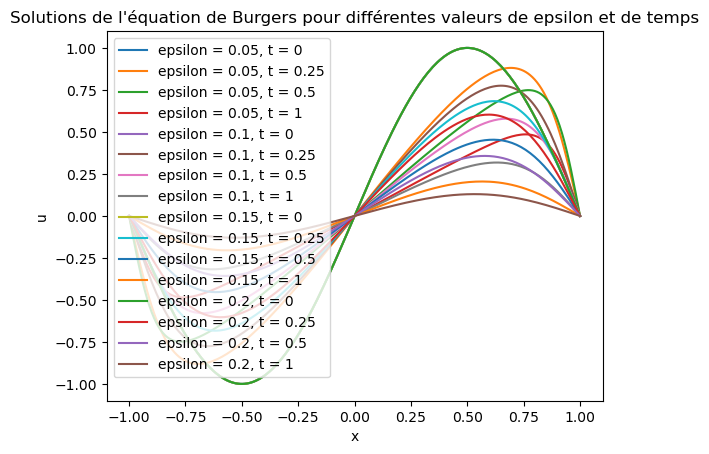

torch.Size([16, 200])


In [13]:
# Différentes valeurs de epsilon et de temps
epsilons = [0.05, 0.1,0.15, 0.2]
times = [0, 0.25, 0.5,1]

# Générer et stocker les solutions
solutions = {}

for epsilon in epsilons:
    for t in times:
        u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        solutions[(epsilon, t)] = u_refer
        plt.plot(x, u_refer, label=f'epsilon = {epsilon}, t = {t}')

plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Solutions de l\'équation de Burgers pour différentes valeurs de epsilon et de temps')
plt.show()

# Convertir les solutions en tenseur PyTorch
data_tensor = torch.stack([torch.tensor(solutions[(epsilon, t)], dtype=torch.float32) if isinstance(solutions[(epsilon, t)], np.ndarray) else solutions[(epsilon, t)].float() for epsilon in epsilons for t in times])
print(data_tensor.shape)  # Afficher la forme du tenseur de données

### Question 4.2 (Réduction de dimension)
Utilisez une méthode POD pour construire notre espace réduit.


Tout d'abord, on commence par calculer la moyenne pour générer l'espace réduit 
$$
 X = [u_h(t_1, \mu_1) - u_{ref}, \ldots, u_h(t_m, \mu_m) - u_{ref}] 
$$

In [4]:
snapchot  = data_tensor.T
U_ref = torch.mean(snapchot, dim=1)
Matrix_X = torch.stack([Uh - U_ref for Uh in snapchot.T], dim=1)
Matrix_X.shape

torch.Size([200, 16])

On va utiliser la méthode de décomposition en valeurs singulières (SVD), puis on détermine les valeurs propres les plus énergétiques.

In [5]:
# Convertir Matrix_X en numpy array pour SVD
Matrix_X_np = Matrix_X.numpy()

# Calculer la décomposition en valeurs singulières (SVD)
U, S, Vt = svd(Matrix_X_np, full_matrices=False)

# Calculer l'énergie totale
total_energy = np.sum(S**2)

# Calculer l'énergie cumulée et déterminer le nombre de valeurs singulières nécessaires pour atteindre 99% de l'énergie totale
cumulative_energy = np.cumsum(S**2)
num_singular_values_99 = np.searchsorted(cumulative_energy, 0.9 * total_energy) + 1
num_singular_values_plus_riche = np.searchsorted(cumulative_energy, 0.9999999 * total_energy) + 1

print(f"Nombre de valeurs singulières nécessaires pour atteindre 99% de l'énergie totale: {num_singular_values_99}")
print(f"Nombre de valeurs singulières nécessaires pour atteindre 99,99999% de l'énergie totale: {num_singular_values_plus_riche}")


Nombre de valeurs singulières nécessaires pour atteindre 99% de l'énergie totale: 1
Nombre de valeurs singulières nécessaires pour atteindre 99,99999% de l'énergie totale: 5


On va utiliser ce nombre pour générer l'espace réduit pour 99% d'énergie.

In [6]:
# Sélectionner les premiers modes pour construire l'espace réduit
num_modes_99 = 2  # Nombre de modes à conserver
Phi_K_99 = U[:, :num_modes_99]
num_modes_plus_riche = 5  # Nombre de modes à conserver
Phi_K_plus_riche = U[:, :num_modes_plus_riche]
print(f'Phi_K_99 shape: {Phi_K_99.shape}')
print(f'Phi_K_plus_riche shape: {Phi_K_plus_riche.shape}')

Phi_K_99 shape: (200, 2)
Phi_K_plus_riche shape: (200, 5)


### Question 4.3 (Réduction de modèle)
Calculer le modèle réduit (sans hyper-réduction) par la méthode de Galerkin, comparez les résultats aux solutions de références et aux solutions PINNs pour plusieurs dimensions de réduction.

On va faire la projection de nos données (les snapshots) sur notre base réduite, pour obtenir les résultats représentant 99% de l'énergie et les plus riches en termes d'énergie.

In [7]:
# On commance par etudier le cas pour 99% de l'energie  
# La solution dans l'espace reduit
a = Phi_K_99.T  @ (Matrix_X.numpy() + U_ref[:, np.newaxis].numpy())

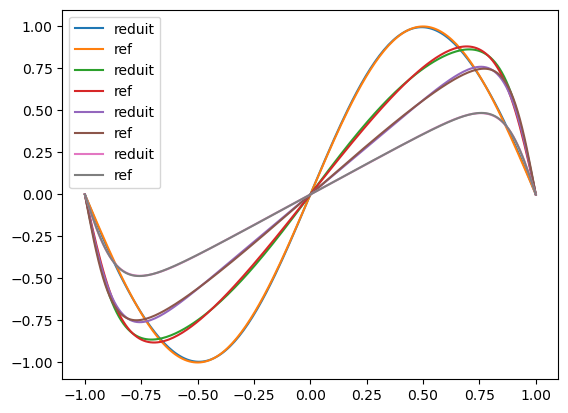

In [8]:
# On le projete pour visualiser les resultat et aussi calculer les erreurs 
X_red = Phi_K_99 @  a  
for i in range (4):
    plt.plot(x, X_red[:, i] , label='reduit')
    plt.plot(x, Matrix_X_np[:, i] + U_ref.numpy(), label='ref')
plt.legend()
plt.show()

Calculer les erreurs avec la solution de référence et la solution de différences finies.

0.08517952
0.20730966
0.17203958
0.015963072
0.08517952
0.3633186
0.27722368
0.18652186
0.08517952
0.3597168


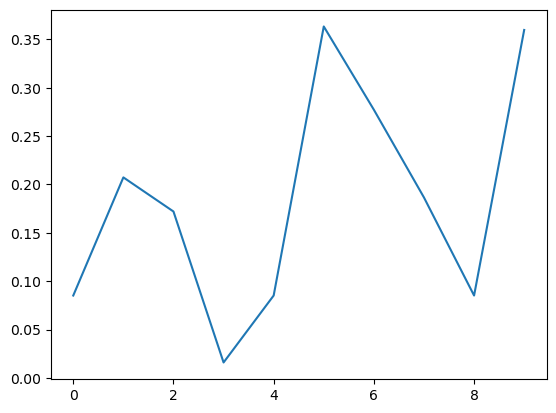

In [9]:
# pour un nombres finis des cas 
list = []

for i in range(10):
    T = np.linalg.norm(X_red[:, i] - ( Matrix_X_np[:, i]+ U_ref.numpy()))
    list.append(T)
    print(T)
plt.plot(range(10),list)
plt.show()

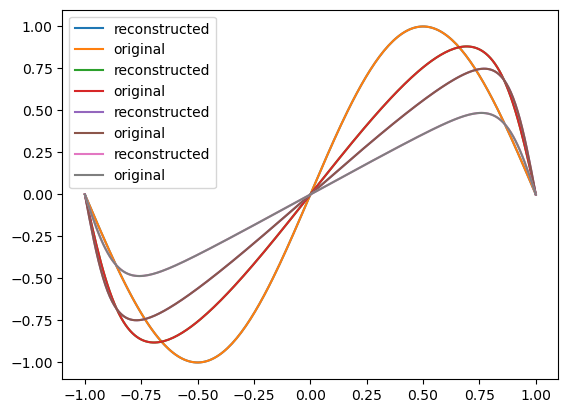

In [10]:
# Le cas ou trés riche en terme d'energie 
a = Phi_K_plus_riche.T  @ (Matrix_X.numpy() + U_ref[:, np.newaxis].numpy())
X_red = Phi_K_plus_riche @ ( a )  
for i in range (4):
    plt.plot(x, X_red[:, i] , label='reconstructed')
    plt.plot(x, Matrix_X_np[:, i] + U_ref.numpy(), label='original')
plt.legend()
plt.show()

0.00028525144
0.00024374011
0.0004107384
1.8157514e-05
0.00028525144
0.00088500563
0.00046801017
0.00031186105
0.00028525144
8.616755e-05


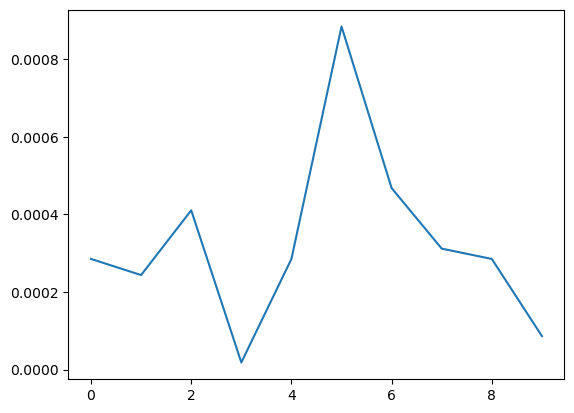

In [11]:
list = []

for i in range(10):
    T = np.linalg.norm(X_red[:, i] - ( Matrix_X_np[:, i]+ U_ref.numpy()))
    list.append(T)
    print(T)
plt.plot(range(10),list)
plt.show()

On voit que les erreurs ne sont pas stables, mais elles sont d'ordre $1$ et $2$ pour $99%$ d'énergie, et d'ordre $4$ et $5$ pour les plus riches en termes d'énergie.

### Question 4.4 (Apprentissage de modèle)
Apprenez le modèle réduit par une approche supervisée et comparez les résultats aux solutions de références et aux solutions PINNs pour plusieurs dimensions de réduction.

On va utiliser les PINNs pour apprendre le modèle et tester les deux cas précédents en donnant les résultats et les erreurs obtenus par apprentissage.

#### Cas 1 : 99% d'energie 

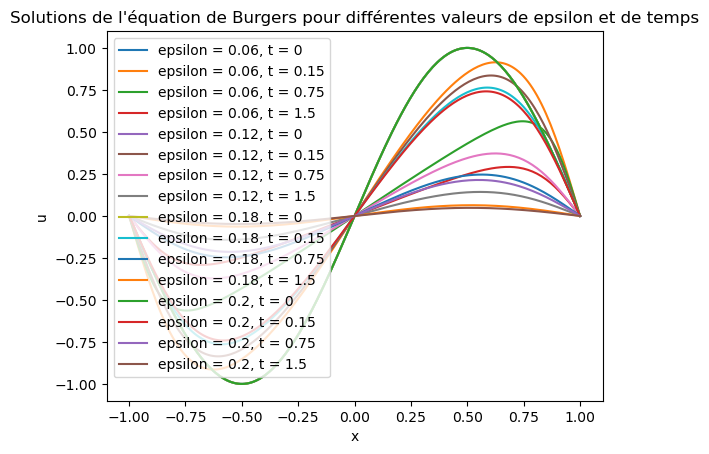

torch.Size([16, 200])


In [25]:
# Différentes valeurs de epsilon et de temps
epsilons = [0.06, 0.12,0.18, 0.2]
times = [0, 0.15, 0.75,1.5]

# Générer et stocker les solutions
solutions = {}

for epsilon in epsilons:
    for t in times:
        u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        solutions[(epsilon, t)] = u_refer
        plt.plot(x, u_refer, label=f'epsilon = {epsilon}, t = {t}')

plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Solutions de l\'équation de Burgers pour différentes valeurs de epsilon et de temps')
plt.show()

# Convertir les solutions en tenseur PyTorch
data_entainement = torch.stack([torch.tensor(solutions[(epsilon, t)], dtype=torch.float32) if isinstance(solutions[(epsilon, t)], np.ndarray) else solutions[(epsilon, t)].float() for epsilon in epsilons for t in times])
print(data_entainement.shape)  # Afficher la forme du tenseur de données

In [26]:
# Préparer les données pour l'apprentissage supervisé
data_entainement = data_entainement.numpy()
coefficients = Phi_K_99.T @ Matrix_X_np

# Définir le réseau de neurones
class ReducedModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ReducedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, output_dim)
    
    def forward(self, x):
        y = torch.tanh(self.fc1(x))
        z = torch.tanh(self.fc2(y))
        t = torch.tanh(self.fc3(z))
        f = self.fc4(t)
        return f

# Préparer les données d'entrée et de sortie pour l'entraînement
input_data = torch.tensor(Phi_K_99.T @  data_entainement.T, dtype=torch.float32)
output_data = torch.tensor(coefficients, dtype=torch.float32)

# Initialiser le modèle, la perte et l'optimiseur
model = ReducedModel(input_dim=16, output_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_data)
    loss = criterion(outputs, output_data)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



Epoch 0, Loss: 4.55899715423584
Epoch 500, Loss: 4.3923198411732756e-15
Epoch 1000, Loss: 7.216449660063518e-16
Epoch 1500, Loss: 6.123573870198129e-16
Epoch 2000, Loss: 5.429684479807406e-16
Epoch 2500, Loss: 1.979319486089537e-15
Epoch 3000, Loss: 1.708702623837155e-15
Epoch 3500, Loss: 4.026293187742169e-15
Epoch 4000, Loss: 8.43769498715119e-15
Epoch 4500, Loss: 7.960646031257568e-15


On va tester notre model et calculer les erreurs

Error_99, , , error = 6.71e-02


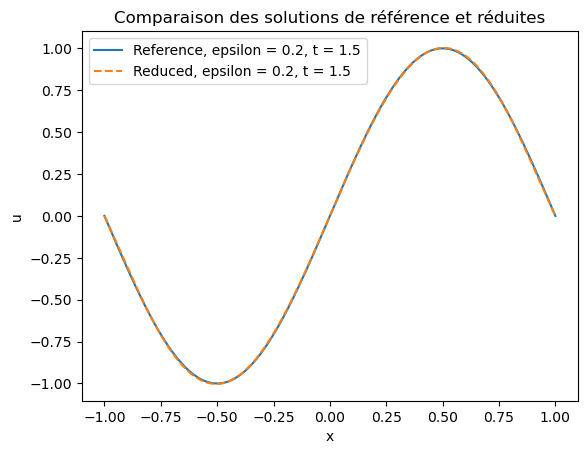

Error_99, , , error = 5.83e-02


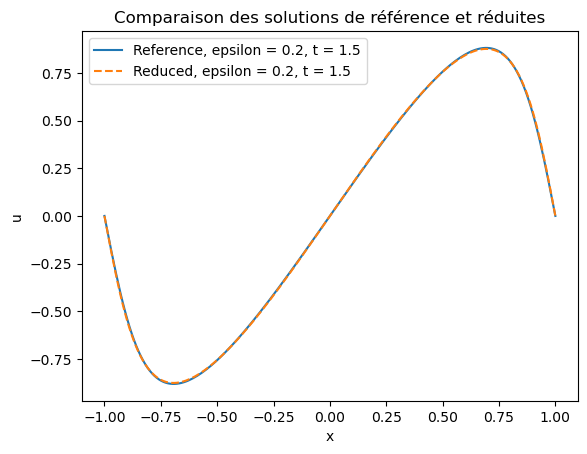

Error_99, , , error = 3.17e-01


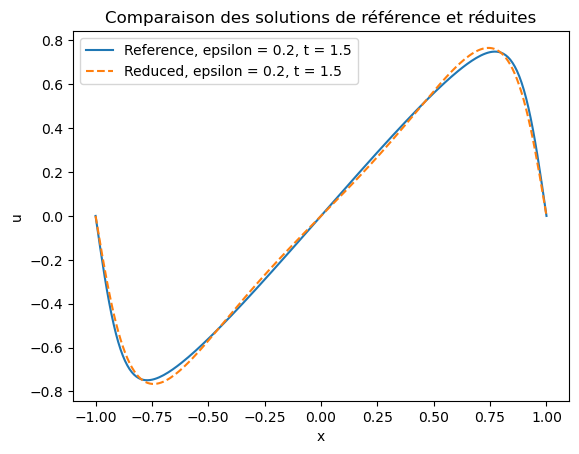

Error_99, , , error = 1.58e-01


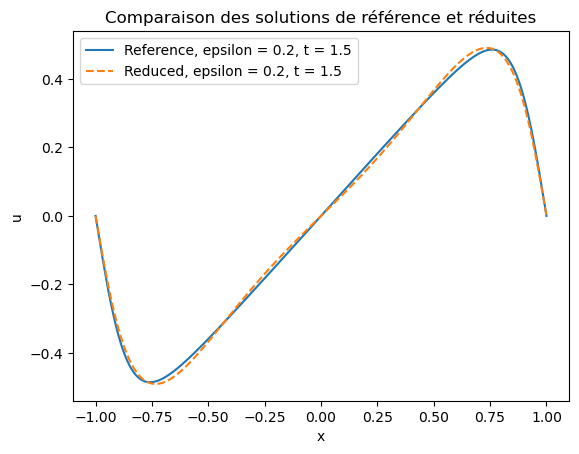

Error_99, , , error = 6.71e-02


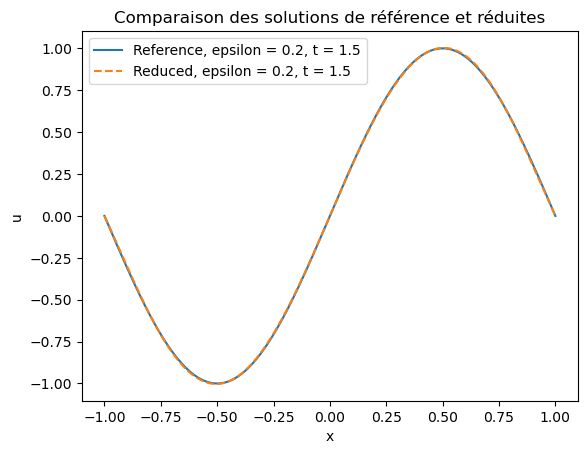

In [28]:
# Comparer les résultats aux solutions de référence et aux solutions PINNs
epsilons = [0.05, 0.1]
times = [0 , 0.5]
model.eval()
with torch.no_grad():
    for i in range(5):
        input_sample = torch.tensor(Phi_K_99.T @  data_entainement.T, dtype=torch.float32)
        predicted_coefficients = model(input_sample).detach().numpy()
        u_reduced = Phi_K_99 @ predicted_coefficients  + U_ref[:,np.newaxis].numpy()
        e = np.linalg.norm((Matrix_X_np[:,i] + U_ref.numpy()) - u_reduced[:,i], ord=2)
        print(f'Error_99, , , error = {e:.2e}')
            # u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        plt.plot(x, Matrix_X_np[:,i] + U_ref.numpy() , label=f'Reference, epsilon = {epsilon}, t = {t}')
        plt.plot(x, u_reduced[:,i], '--', label=f'Reduced, epsilon = {epsilon}, t = {t}')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.title('Comparaison des solutions de référence et réduites')
        plt.show()
            

#### Cas 2 : Plus riche en terme de l'energie

In [29]:
# Préparer les données pour l'apprentissage supervisé
coefficients = Phi_K_plus_riche.T @ Matrix_X_np

# Définir le réseau de neurones
class ReducedModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ReducedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, output_dim)
    
    def forward(self, x):
        y = torch.tanh(self.fc1(x))
        z = torch.tanh(self.fc2(y))
        t = torch.tanh(self.fc3(z))
        f = self.fc4(t)
        return f

# Préparer les données d'entrée et de sortie pour l'entraînement
input_data = torch.tensor(Phi_K_plus_riche.T @  data_entainement.T, dtype=torch.float32)
output_data = torch.tensor(coefficients, dtype=torch.float32)

# Initialiser le modèle, la perte et l'optimiseur
model = ReducedModel(input_dim=16, output_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_data)
    loss = criterion(outputs, output_data)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



Epoch 0, Loss: 1.8656059503555298
Epoch 500, Loss: 0.00031800518627278507
Epoch 1000, Loss: 0.00012327372678555548
Epoch 1500, Loss: 9.786584269022569e-05
Epoch 2000, Loss: 7.526286208303645e-05
Epoch 2500, Loss: 5.656980283674784e-05
Epoch 3000, Loss: 4.354616248747334e-05
Epoch 3500, Loss: 3.4074884752044454e-05
Epoch 4000, Loss: 2.4971475795609877e-05
Epoch 4500, Loss: 1.5092764442670159e-05


Error_99, , , error = 2.17e-03


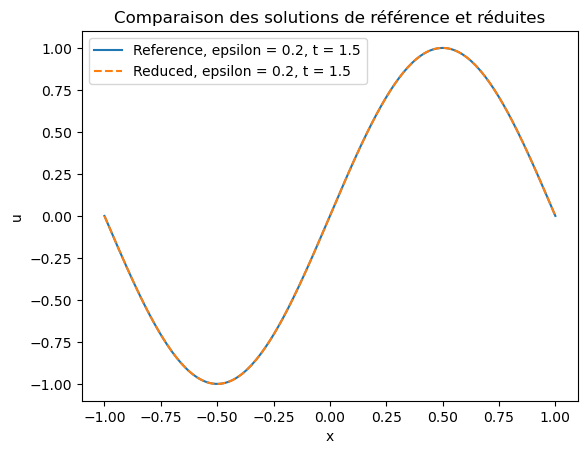

Error_99, , , error = 1.71e-03


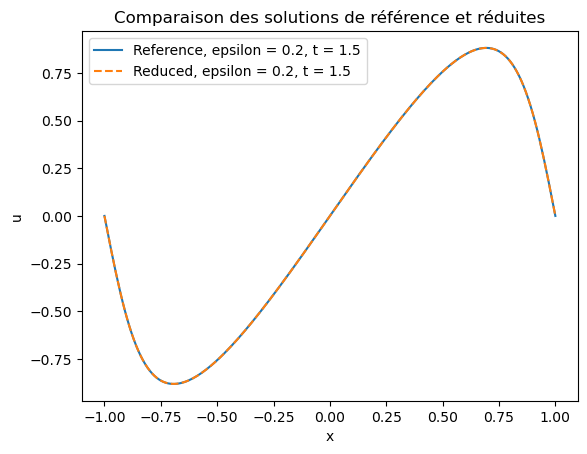

Error_99, , , error = 1.17e-02


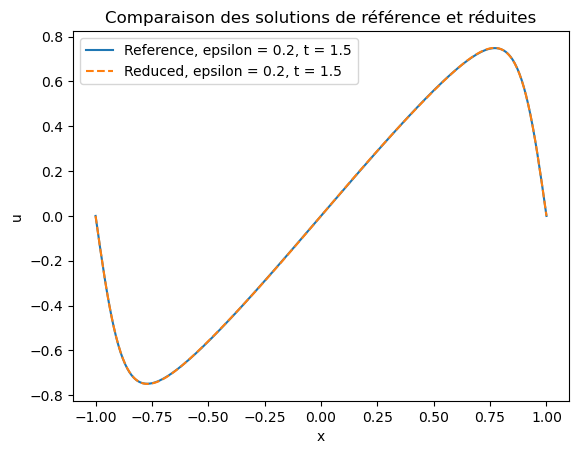

Error_99, , , error = 1.48e-02


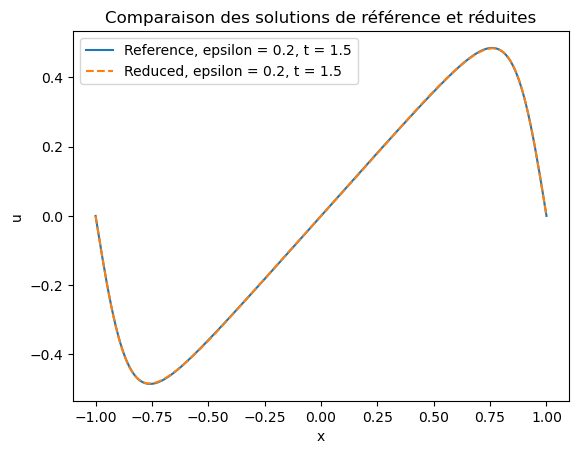

Error_99, , , error = 3.84e-03


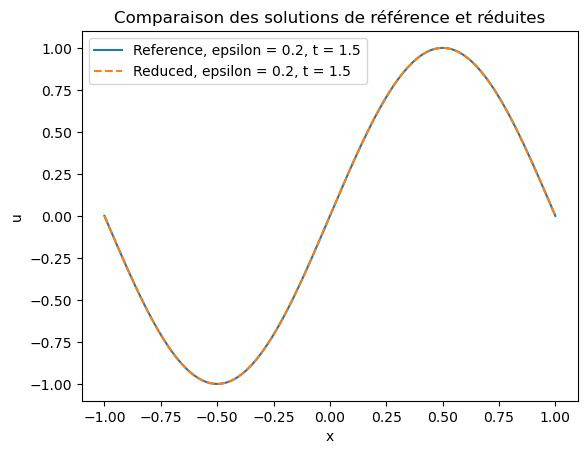

In [30]:
# Comparer les résultats aux solutions de référence et aux solutions PINNs
epsilons = [0.05, 0.1]
times = [0 , 0.5]
model.eval()
with torch.no_grad():
    for i in range(5):
        input_sample = torch.tensor(Phi_K_plus_riche.T @  data_entainement.T, dtype=torch.float32)
        predicted_coefficients = model(input_sample).detach().numpy()
        u_reduced = Phi_K_plus_riche @ predicted_coefficients  + U_ref[:,np.newaxis].numpy()
        e = np.linalg.norm((Matrix_X_np[:,i] + U_ref.numpy()) - u_reduced[:,i], ord=2)
        print(f'Error_99, , , error = {e:.2e}')
            # u_refer = scheme_refer(epsilon, L, nx, u0_U0, t)
        plt.plot(x, Matrix_X_np[:,i] + U_ref.numpy() , label=f'Reference, epsilon = {epsilon}, t = {t}')
        plt.plot(x, u_reduced[:,i], '--', label=f'Reduced, epsilon = {epsilon}, t = {t}')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.title('Comparaison des solutions de référence et réduites')
        plt.show()
            

On constate presque les mêmes observations que dans la question précédente, car pour 99% de l'énergie, on a un ordre d'erreur de 1 et 2, et pour les cas plus riches en termes d'énergie, on a un ordre de 3 et 4, ce qui montre que le modèle prédit bien le problème.

## 5. Exercice 3: Bonus Réduction de modèle

Cela donnera des points en plus sur la moyenne générale (si le reste est fait).

### Question 5.1 (Réduction de dimension)

Utilisez un auto-encodeur pour construire notre espace réduit et apprenez le modèle réduit par la méthode de votre choix (apprentissage de flot, d’EDO, RNN) etc.

On commence par la construction de notre espace réduit en utilisant un auto-encodeur.

In [ ]:
# Définir l'auto-encodeur
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Paramètres de l'auto-encodeur
input_dim = nx  # Dimension d'entrée (nombre de points spatiaux)
latent_dim = 10  # Dimension de l'espace réduit

# Initialiser l'auto-encodeur, la fonction de perte et l'optimiseur
autoencoder = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Préparer les données pour l'entraînement
X_tensor = data_tensor.reshape(-1, nx).clone().detach().float()
Y_tensor = torch.tensor(data_entainement.reshape(-1, nx), dtype=torch.float32).clone().detach()
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Entraînement de l'auto-encodeur
epochs = 100
for epoch in range(epochs):
    for batch in dataloader:
        x, _ = batch
        optimizer.zero_grad()
        x_recon, z = autoencoder(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Extraire les représentations latentes (espace réduit)
with torch.no_grad():
    _, Z = autoencoder(X_tensor)
    Z = Z.numpy()
    print(f"Latent space shape: {Z.shape}")

Epoch [10/100], Loss: 0.1055
Epoch [20/100], Loss: 0.0179
Epoch [30/100], Loss: 0.0125
Epoch [40/100], Loss: 0.0091
Epoch [50/100], Loss: 0.0074
Epoch [60/100], Loss: 0.0063
Epoch [70/100], Loss: 0.0054
Epoch [80/100], Loss: 0.0046
Epoch [90/100], Loss: 0.0039
Epoch [100/100], Loss: 0.0028
Latent space shape: (16, 10)
